In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [52]:
main = pd.read_csv(r'C:\Users\Anna\Downloads\1481069814_relax_challenge\relax_challenge\takehome_users.csv',encoding='latin-1')
usage = pd.read_csv(r'C:\Users\Anna\Downloads\1481069814_relax_challenge\relax_challenge\takehome_user_engagement.csv')

In [8]:
main.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In order to determine whether a user is adopted or not, we need to look for 3 separate logins in a 7 day period. To do this based on the data we will need to use the usage table to find the users who are adopted. The easiest way is to write a function to check whether a user is adopted or not. First to make this easier, I will change the time stamp and change it to the index to make it easier to check.

In [11]:
usage.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [53]:
import datetime 
from datetime import timedelta

usage.time_stamp = pd.to_datetime(usage.time_stamp)
usage = usage.set_index('time_stamp', drop= True)



In [25]:
def is_adopted(x):
    "returns whether or not a specified user has been adopted or not"
    temp = usage.loc[usage['user_id'] == x] 
    df_temp = temp.resample('D').mean().dropna() #resample by day, need mean in order to drop nulls 
    adopted = 0
    for i in range(len(df_temp)-2): #loop over all days till the second to last to catch all dates in range
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted
    

In [54]:
main['adopted_user'] = main['object_id'].apply(is_adopted)

In [46]:
main['adopted_user'].describe()

count    12000.000000
mean         0.138000
std          0.344914
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: adopted_user, dtype: float64

In [28]:
print(sum(main.adopted_user))

1656


In [29]:
print(sum(main.adopted_user)/len(main.adopted_user))

0.138


Now we know that of the 12000, 1656 of them were actually adopted, about 14% of them. In order to see what features contribute the most to this, we need to massage the data some more. We need to convert some more of the dataframe into datetimes and then look at other features we can test on. 

In [55]:
main['creation_time']=pd.to_datetime(main['creation_time'])

In [56]:
main['last_session_creation_time'] = main['last_session_creation_time'].map(lambda data: datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
 na_action='ignore')
main['last_session_creation_time'] = pd.to_datetime(main['last_session_creation_time'])


In [60]:
main['usage_len'] = main['last_session_creation_time'] - main['creation_time']

In [66]:
main['usage_len'] = [x.total_seconds() for x in main['usage_len']] #convert to seconds to make the time passage easier to read

In [67]:
main['usage_len'].describe()

count    8.823000e+03
mean     5.090581e+06
std      1.245681e+07
min     -2.880000e+04
25%     -2.520000e+04
50%      6.120000e+04
75%      1.702800e+06
max      6.296040e+07
Name: usage_len, dtype: float64

In [68]:
#Let's fill in some missing values 
main['invited_by_user_id'] = main['invited_by_user_id'].fillna(0)

We can also use email addresses as a feature, but we need to clean it up a bit. 

In [69]:
main['email_provider'] = [x.split('@')[1] for x in main.email]#pick out the email 

In [82]:
#Now let's drop the features we no longer need, and leave the dataframe we will work with
final_df= main.drop(['object_id','creation_time','name','email','last_session_creation_time'],axis=1)
df = final_df.fillna(0)

In [83]:
df.usage_len[df['usage_len']<0]=0

C:\Users\Anna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_len,email_provider
0,GUEST_INVITE,1,0,11,10803.0,0,0.0,yahoo.com
1,ORG_INVITE,0,0,1,316.0,1,11725200.0,gustr.com
2,ORG_INVITE,0,0,94,1525.0,0,0.0,gustr.com
3,GUEST_INVITE,0,0,1,5151.0,0,61200.0,yahoo.com
4,GUEST_INVITE,0,0,193,5240.0,0,403200.0,yahoo.com


Now just one more step before we can work on our model, we need to label encode for the features that are categorical but currently have strings/objects as their data. We will do this by fitting and transforming label encoders.

In [91]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
creation_labels = le.fit_transform(df['creation_source'])
df['creation_source'] = creation_labels

org_labels = le.fit_transform(df['org_id'])
df['org_id'] = org_labels

invited_labels = le.fit_transform(df['invited_by_user_id'])
df['invited_by_user_id'] = invited_labels

email_labels = le.fit_transform(df['email_provider'])
df['email_provider'] = email_labels

In [92]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_len,email_provider
0,0,1,0,11,2325,0,0.0,1112
1,1,0,0,1,56,1,11725200.0,306
2,1,0,0,94,298,0,0.0,306
3,0,0,0,1,1104,0,61200.0,1112
4,0,0,0,193,1127,0,403200.0,1112


Now this is ready for modeling. We will use the Random Forest Classifier here to deal with the relatively large dataset as well as to deal with numerical and categorical features. 

In [93]:
from sklearn.model_selection import train_test_split

x = df.drop('adopted_user', axis=1) #separate out the labels to do train test 
y = df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(x, y, test_size=0.3, random_state=23)

In [94]:
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier()
rfc.fit(X_train, X_test)

C:\Users\Anna\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [121]:
rfc.score(y_train, y_test)

0.9730555555555556

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rfc.predict(y_train)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3094
           1       0.93      0.88      0.90       506

   micro avg       0.97      0.97      0.97      3600
   macro avg       0.95      0.93      0.94      3600
weighted avg       0.97      0.97      0.97      3600

[[3059   35]
 [  62  444]]


In [102]:
feature_importance = pd.DataFrame()
feature_importance['imp'] = rfc.feature_importances_
feature_importance = feature_importance.set_index(x.columns)

In [111]:
final = feature_importance.sort_values('imp',ascending=False)
final

,imp
usage_len,0.875909
org_id,0.055136
invited_by_user_id,0.032747
email_provider,0.019100
creation_source,0.010055
opted_in_to_mailing_list,0.004891
enabled_for_marketing_drip,0.002163


Text(0,0.5,'Importance Coefficient')

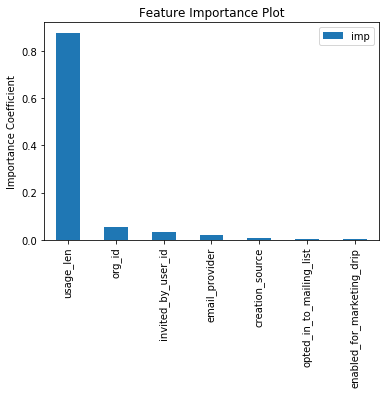

In [117]:
final.plot(kind='bar')
plt.title('Feature Importance Plot')
plt.ylabel('Importance Coefficient')